<a href="https://colab.research.google.com/github/Esantomi/digital-humanities/blob/main/%EC%9D%B8%EB%AC%B8%EC%A7%80%EC%8B%9D%EC%B2%98%EB%A6%AC%EC%99%80%ED%86%B5%EA%B3%84/06_%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%96%B8%EC%96%B4_%EB%B6%84%EB%A5%98_with_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 환경설정
import time

from IPython.display import clear_output
clear_output(wait=True)

!pip install konlpy

import sys
import tensorflow as tf
import keras
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
import konlpy
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

!pip install simplejson

import io
import simplejson as json

from tensorflow.keras.layers import Dense, Embedding, LSTM, Flatten, Dropout, Input, Conv1D, MaxPooling1D, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

clear_output()

print('Python version : ', sys.version)
print('TensorFlow version : ', tf.__version__)
print('Keras version : ', keras.__version__)
print('konlpy version : ', konlpy.__version__)

Python version :  3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
TensorFlow version :  2.6.0
Keras version :  2.6.0
konlpy version :  0.5.2


In [ ]:
#@title 데이터 불러오기 - Naver sentiment movie corpus v1.0
구글드라이브ID = '1EbnxOYEt4PJxVN_z1SO2iLMSw4JSkmdV'  #@param {type: "string"}
파일저장이름 = 'rawdata.txt'  #@param {type: "string"}

## 데이터 출처: Naver sentiment movie corpus v1.0
## https://github.com/e9t/nsmc


# 구글 드라이브 연결을 위한 기본 세팅
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 문서 ID로 실제 파일 불러오는 법
## https://drive.google.com/open?id=1EbnxOYEt4PJxVN_z1SO2iLMSw4JSkmdV
###label,text
###긍정,어릴때보고 지금다시봐도 재밌어요ㅋㅋ
###긍정,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다."
###긍정,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.
###부정,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.
###부정,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ
###부정,포풍저그가나가신다영차영차영차

# 실습을 위한 간단 데이터 - 긍정 100개 부정 100개
# https://drive.google.com/open?id=1pHM41cWacOvMT5bl7TGTmxMLL_tl6M6n
rawdata_downloaded = drive.CreateFile({'id': 구글드라이브ID })
rawdata_downloaded.GetContentFile(파일저장이름)

## 하단은 Full DATA - 긍정 99,996개 부정 99,996개
## https://drive.google.com/open?id=1EbnxOYEt4PJxVN_z1SO2iLMSw4JSkmdV
#rawdata_downloaded = drive.CreateFile({'id': '1EbnxOYEt4PJxVN_z1SO2iLMSw4JSkmdV'})
#rawdata_downloaded.GetContentFile('rawdata.txt')

print(파일저장이름+"을 정상적으로 가져왔습니다.")

# 파일을 DataFrame으로 전환
df = pd.read_csv(파일저장이름, header=0, encoding='utf-8', engine='python')
df = df.sample(frac=1) ## 데이터 랜덤으로 섞기
df

rawdata.txt을 정상적으로 가져왔습니다.


,label,text
20640,긍정,드라마안보는 내가처음부터끝까지 본드라마 요즘티비에서하는데 약간유치하긴하네^^;
66386,긍정,개 꿀잼 ㅋㅋ 진짜 시간가는줄모르고봣네요
92967,긍정,재미이다
9990,긍정,다른평들처럼티비에서질리도록해줬는데질리지않고볼수있었던영화.아매의만두가정말먹어보고싶었고...
124819,부정,이 영화 더빙판 절대 보지마세요.(영화 자체는 훌륭한데 더빙이 다 망쳐놈)
...,...,...
31713,긍정,뻔한스토리지만 힐링제대로됨
24007,긍정,파이데이니까 10점.
191350,부정,쓰레기..10자 채움
24731,긍정,역대 은행털이 영화중 최고다. 단순한거 좋아하는 사람들은 재미없을듯.


## 데이터 전처리

In [ ]:
#@title 데이터 선택하기

데이터량 = "10000"  #@param ['100', '1000', '5000','10000', '100000', '199991']

데이터량 = int(데이터량)
df = df.iloc[:데이터량]
print(df)

print(df["label"].groupby([df["label"]]).count())


       label                                               text
20640     긍정        드라마안보는 내가처음부터끝까지 본드라마 요즘티비에서하는데 약간유치하긴하네^^;
66386     긍정                             개 꿀잼 ㅋㅋ 진짜 시간가는줄모르고봣네요
92967     긍정                                               재미이다
9990      긍정  다른평들처럼티비에서질리도록해줬는데질리지않고볼수있었던영화.아매의만두가정말먹어보고싶었고...
124819    부정          이 영화 더빙판 절대 보지마세요.(영화 자체는 훌륭한데 더빙이 다 망쳐놈)
...      ...                                                ...
55598     긍정  괜찮은 프랑스산 로맨스 영화. 클리셰도 꽤 보이지만, 기대한것에 비하면 훌륭함. 결...
14235     긍정  지금 보고 있는데 나름 재미있네요우연히 오진을 선고 받는 주인공과 사랑이와의사랑 그...
176948    부정  정신병자같은 저 최선정 연기가 잘하는거면 나도한다그딴연기 방송으로 내보내는 감독도 ...
47511     긍정                                    한국 조폭영화 보단 나은데/
52184     긍정                         말로표현을못함 작가천재임 배우들도진짜캐스팅굿rr

[10000 rows x 2 columns]
label
긍정    5066
부정    4934
Name: label, dtype: int64


In [ ]:
## 텍스트로 되어 있는 라벨을 숫자로 변환
df.loc[df.label=='긍정', 'label']='0'
df.loc[df.label=='부정', 'label']='1'
#df.loc[df.label=='무언인가', 'label']='2'

print(df)



       label                                               text
20640      0        드라마안보는 내가처음부터끝까지 본드라마 요즘티비에서하는데 약간유치하긴하네^^;
66386      0                             개 꿀잼 ㅋㅋ 진짜 시간가는줄모르고봣네요
92967      0                                               재미이다
9990       0  다른평들처럼티비에서질리도록해줬는데질리지않고볼수있었던영화.아매의만두가정말먹어보고싶었고...
124819     1          이 영화 더빙판 절대 보지마세요.(영화 자체는 훌륭한데 더빙이 다 망쳐놈)
...      ...                                                ...
55598      0  괜찮은 프랑스산 로맨스 영화. 클리셰도 꽤 보이지만, 기대한것에 비하면 훌륭함. 결...
14235      0  지금 보고 있는데 나름 재미있네요우연히 오진을 선고 받는 주인공과 사랑이와의사랑 그...
176948     1  정신병자같은 저 최선정 연기가 잘하는거면 나도한다그딴연기 방송으로 내보내는 감독도 ...
47511      0                                    한국 조폭영화 보단 나은데/
52184      0                         말로표현을못함 작가천재임 배우들도진짜캐스팅굿rr

[10000 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid d

In [ ]:
#@title 훈련데이터와 테스트 데이터 분리

훈련데이터비율 = 0.9  #@param ['0.9', '0.8', '0.7', '0.6']

## 훈련데이터와 테스트데이터로 분리
train=df.sample(frac=훈련데이터비율,random_state=200)
test=df.drop(train.index)

train.drop_duplicates(subset = ['text'], inplace=True) # text 열에서 중복인 내용이 있다면 중복 제거
train['text'] = train['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
train['text'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
train = train.dropna(how='any') # Null 값 제거
print('전처리 후 훈련용 샘플의 개수 :',len(train))

test.drop_duplicates(subset = ['text'], inplace=True) # text 열에서 중복인 내용이 있다면 중복 제거
test['text'] = test['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test['text'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test = test.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test))

전처리 후 훈련용 샘플의 개수 : 8885
전처리 후 테스트용 샘플의 개수 : 993


In [ ]:
#@title 토큰화(형태소 분석)

단어최소출현횟수 = 0  #@param {type: "slider", min: 0, max: 100}

start = time.time() # 시작시간

okt = Okt()

X_train = []
for sentence in train['text']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    X_train.append(temp_X)

X_test = []
for sentence in test['text']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    X_test.append(temp_X)   

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

print("토큰화결과: "+str(tokenizer.word_index))

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 단어최소출현횟수 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

vocab_size = total_cnt - rare_cnt + 1 # 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거. 0번 패딩 토큰을 고려하여 +1
print('단어 집합의 크기 :',vocab_size)

vocab_size = total_cnt


# 끝난 시간에서 시작시각을 빼서 걸린 시간을 구한다.
end = time.time()
elapsed = (end - start)/60
print("소요시간 : ", elapsed, "Min.")


토큰화결과: {'이': 1, '영화': 2, '하다': 3, '보다': 4, '의': 5, '가': 6, '에': 7, '을': 8, '도': 9, '들': 10, '는': 11, '를': 12, '은': 13, '없다': 14, '이다': 15, '좋다': 16, '있다': 17, '다': 18, '너무': 19, '한': 20, '정말': 21, '재밌다': 22, '되다': 23, '적': 24, '진짜': 25, '같다': 26, '로': 27, '만': 28, '점': 29, '아니다': 30, '으로': 31, '않다': 32, '에서': 33, '평점': 34, '최고': 35, '것': 36, '과': 37, '내': 38, '나오다': 39, '만들다': 40, '그': 41, '인': 42, '연기': 43, '안': 44, '못': 45, '나': 46, '생각': 47, '드라마': 48, '스토리': 49, '왜': 50, '게': 51, '감동': 52, '때': 53, '아깝다': 54, '이렇다': 55, '말': 56, '더': 57, '사람': 58, 'ㅋㅋ': 59, '아': 60, '내용': 61, '보고': 62, '와': 63, '거': 64, '배우': 65, '감독': 66, '뭐': 67, '시간': 68, '그냥': 69, '요': 70, '고': 71, '재미있다': 72, '주다': 73, '중': 74, '까지': 75, '자다': 76, '재미': 77, '쓰레기': 78, '네': 79, '재미없다': 80, '작품': 81, '수': 82, '가다': 83, '하고': 84, '모르다': 85, '들다': 86, '하나': 87, '알다': 88, '지루하다': 89, '다시': 90, '좀': 91, '그렇다': 92, '사랑': 93, '지': 94, 'ㅠㅠ': 95, '싶다': 96, '많다': 97, '완전': 98, '볼': 99, '차다': 100, '정도': 101, '이건': 102, '잘

In [ ]:
#@title 워드 임베딩

start = time.time() # 시작시간

print("워드 임베딩 결과 샘플 - 원문")
print(X_train[:3])

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

print("워드 임베딩 결과 샘플 - 임베딩 결과물")
print(X_train[:3])

y_train = np.array(train['label'])
y_test = np.array(test['label'])

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2) ## 최종 분류 숫자에 따라 숫자 변경 필요
y_test = to_categorical(y_test, 2) ## 최종 분류 숫자에 따라 숫자 변경 필요

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

# 끝난 시간에서 시작시각을 빼서 걸린 시간을 구한다.
end = time.time()
elapsed = (end - start)/60
print("소요시간 : ", elapsed, "Min.")


워드 임베딩 결과 샘플 - 원문
[['정말', '노잼', '존', 'ㅡ', '나다', '보다', '셈'], ['전쟁', '의', '디테', '일과', '그', '분위기', '를', '연출', '하다', '영', '상미', '는', '지금', '보다', '너무', '훌륭하다', '출연', '하다', '배우', '들', '이', '유명하다', '하나', '의', '보너스'], ['전작', '기대하다', '보다', '이', '게', '스릴러', '인지', '코미디', '인', '디']]
워드 임베딩 결과 샘플 - 임베딩 결과물
[[21, 375, 1515, 717, 114, 4, 1288], [429, 5, 2492, 3906, 41, 450, 13, 119, 3, 176, 625, 11, 115, 4, 19, 309, 404, 3, 66, 10, 1, 764, 87, 5, 3004], [899, 249, 4, 1, 55, 385, 264, 202, 43, 1516]]
소요시간 :  0.003445883591969808 Min.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 12.985669149176259


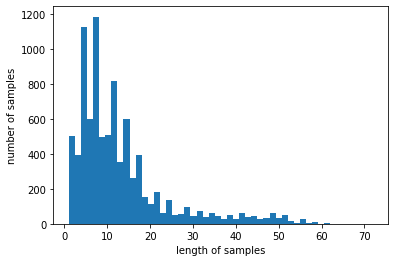

전체 샘플 중 길이가 30 이하인 샘플의 비율: 91.55946738885127
소요시간 :  0.006043374538421631 Min.


In [ ]:
#@title 패딩

start = time.time() # 시작시간

print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train) 

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 끝난 시간에서 시작시각을 빼서 걸린 시간을 구한다.
end = time.time()
elapsed = (end - start)/60
print("소요시간 : ", elapsed, "Min.")



## 딥러닝 학습하기

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(LSTM(128, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) ## 최종 분류 숫자에 따라 숫자 변경 필요

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1558912   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2

In [ ]:
start = time.time() # 시작시간

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=32, validation_split=0.2)

# 끝난 시간에서 시작시각을 빼서 걸린 시간을 구한다.
end = time.time()
elapsed = (end - start)/60
print("소요시간 : ", elapsed, "Min.")

Epoch 1/10
222/222 [==============================] - 11s 18ms/step - loss: 0.5960 - accuracy: 0.6561 - val_loss: 0.4449 - val_accuracy: 0.7857

Epoch 00001: val_loss improved from inf to 0.44490, saving model to best_model.h5
Epoch 2/10
222/222 [==============================] - 3s 14ms/step - loss: 0.3764 - accuracy: 0.8492 - val_loss: 0.4296 - val_accuracy: 0.8020

Epoch 00002: val_loss improved from 0.44490 to 0.42963, saving model to best_model.h5
Epoch 3/10
222/222 [==============================] - 3s 14ms/step - loss: 0.2295 - accuracy: 0.9185 - val_loss: 0.5164 - val_accuracy: 0.7930

Epoch 00003: val_loss did not improve from 0.42963
Epoch 4/10
222/222 [==============================] - 3s 14ms/step - loss: 0.1512 - accuracy: 0.9468 - val_loss: 0.7280 - val_accuracy: 0.7699

Epoch 00004: val_loss did not improve from 0.42963
Epoch 5/10
222/222 [==============================] - 3s 14ms/step - loss: 0.1077 - accuracy: 0.9615 - val_loss: 0.6984 - val_accuracy: 0.7682

Epoch 000

31/31 [==============================] - 1s 17ms/step - loss: 0.4501 - accuracy: 0.7967
정확도 : 0.7967


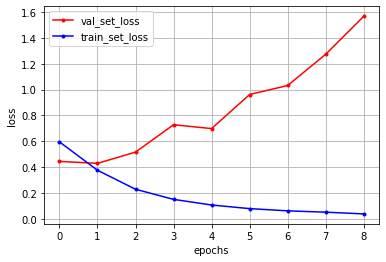

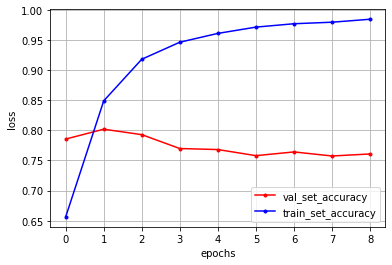

              precision    recall  f1-score   support

         pos       0.82      0.77      0.79       503
         neg       0.77      0.83      0.80       481

    accuracy                           0.80       984
   macro avg       0.80      0.80      0.80       984
weighted avg       0.80      0.80      0.80       984



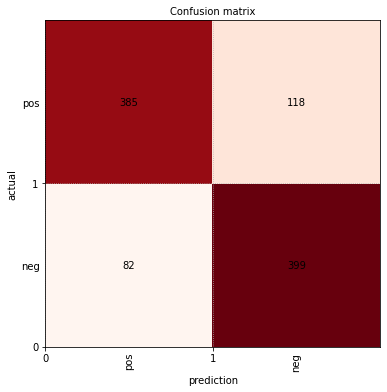

In [ ]:
#@title 딥러닝 모델 훈련 결과 평가하기
라벨링 = ['pos','neg']  #@param

model = load_model('best_model.h5')
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

y_vloss = history.history['val_accuracy']
y_loss = history.history['accuracy']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_accuracy')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

from sklearn.metrics import classification_report
model = load_model('best_model.h5')

y_pred = model.predict(X_test)
rounded_predictions = np.argmax(y_pred, axis=1)
rounded_labels=np.argmax(y_test, axis=1)

labels = 라벨링

print(classification_report(rounded_labels, rounded_predictions, target_names=labels))


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

model = load_model('best_model.h5')

y_pred = model.predict(X_test)
rounded_predictions = np.argmax(y_pred, axis=1)
rounded_labels=np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, rounded_predictions)

def plot_confusion_matrix(
    ax, matrix, labels, title='Confusion matrix', fontsize=9):

    ax.set_xticks([x for x in range(len(labels))])
    ax.set_yticks([y for y in range(len(labels))])

    # Place labels on minor ticks
    ax.set_xticks([x + 0.5 for x in range(len(labels))], minor=True)
    ax.set_xticklabels(labels, rotation='90', fontsize=fontsize, minor=True)
    ax.set_yticks([y + 0.5 for y in range(len(labels))], minor=True)
    ax.set_yticklabels(labels[::-1], fontsize=fontsize, minor=True)

    # Hide major tick labels
    ax.tick_params(which='major', labelbottom='off', labelleft='off')

    # Finally, hide minor tick marks
    ax.tick_params(which='minor', width=0)

    # Plot heat map
    proportions = [1. * row / sum(row) for row in matrix]
    ax.pcolor(np.array(proportions[::-1]), cmap=plt.cm.Reds)

    # Plot counts as text
    for row in range(len(matrix)):
        for col in range(len(matrix[row])):
            confusion = matrix[::-1][row][col]
            if confusion != 0:
                ax.text(col + 0.5, row + 0.5, int(confusion),
                        fontsize=fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')

    # Add finishing touches
    ax.grid(True, linestyle=':')
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel('prediction', fontsize=fontsize)
    ax.set_ylabel('actual', fontsize=fontsize)

    plt.show()


if __name__ == '__main__':
    matrix = cm
    labels = 라벨링
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    plot_confusion_matrix(ax, matrix, labels, fontsize=10)




In [ ]:
#@title 딥러닝 모델로 긍부정 예측하기
모델이름 = 'best_model.h5'  #@param {type: "string"}

model = load_model('best_model.h5')

테스트용텍스트 = '\uC601\uC0C1\uC740 \uC88B\uC73C\uB098 \uBC18\uC804\uAE4C\uC9C0 \uBCF4\uAE30\uC5D4 \uC0B0\uB9CC\uD558\uACE0 \uC9C0\uB8E8\uD558\uACE0 \uAC1C\uC5F0\uC131\uC774\uB5A8\uC5B4\uC9C4\uB2E4.. \uD3C9\uC810\uC5D0\uB09A\uC600\uB124'  #@param {type: "string"}

okt = Okt()
X_test = []

temp_X = okt.morphs(테스트용텍스트, stem=True) # 토큰화
X_test.append(temp_X)
temp_X = tokenizer.texts_to_sequences(X_test)

y_pred = model.predict(temp_X)
rounded_predictions = np.argmax(y_pred, axis=1)

if rounded_predictions==0:
   result = "긍정"
else:
   result = "부정"

print(result, y_pred)

부정 [[0.00110243 0.99889755]]


In [ ]:
#@title 딥러닝 모델로 긍부정 예측하기
모델이름 = 'best_model.h5'  #@param {type: "string"}

model = load_model('best_model.h5')

테스트용텍스트 = '\uC774\uAC74 \uC644\uC804\uD788 \uB0B4 \uC778\uC0DD\uC5D0\uC11C \uB2E4\uC2DC \uBCF4\uC9C0 \uBABB\uD560 \uBA85\uC791\uC774\uB2E4.'  #@param {type: "string"}

okt = Okt()
X_test = []

temp_X = okt.morphs(테스트용텍스트, stem=True) # 토큰화
X_test.append(temp_X)
temp_X = tokenizer.texts_to_sequences(X_test)

y_pred = model.predict(temp_X)
rounded_predictions = np.argmax(y_pred, axis=1)

if rounded_predictions==0:
   result = "긍정"
else:
   result = "부정"

print(result, y_pred)

긍정 [[0.7614869  0.23851308]]


In [ ]:
#@title 딥러닝 모델로 긍부정 예측하기
모델이름 = 'best_model.h5'  #@param {type: "string"}

model = load_model('best_model.h5')

테스트용텍스트 = '\uC6B0\uD558\uD558\uD558. \uC774\uB534 \uC601\uD654\uB3C4 \uC601\uD654\uB0D0? \uD45C \uAC12\uC774 \uC544\uAE5D\uB2E4.'  #@param {type: "string"}

okt = Okt()
X_test = []

temp_X = okt.morphs(테스트용텍스트, stem=True) # 토큰화
X_test.append(temp_X)
temp_X = tokenizer.texts_to_sequences(X_test)

y_pred = model.predict(temp_X)
rounded_predictions = np.argmax(y_pred, axis=1)

if rounded_predictions==0:
   result = "긍정"
else:
   result = "부정"

print(result, y_pred)

부정 [[0.02028961 0.97971046]]


## 딥러닝 모델의 저장 & 불러오기

In [ ]:
#@title 딥러닝 모델 저장하기
저장위치 = '/content/drive/My Drive'  #@param {type: "string"}

tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

from google.colab import drive
drive.mount("/content/drive", force_remount=True)

!cp -r '/content/best_model.h5'  '저장위치'
!cp -r '/content/tokenizer.json' '저장위치'

clear_output()

In [ ]:
#@title 딥러닝 모델 불러오기
모델ID = '14cBYSUTjPu69I3ZrMN8bUO4OtQtyVwaE'  #@param {type: "string"}
모델이름 = 'pn_model.h5'  #@param {type: "string"}
토큰화모델ID = '1GC2cn3rW_GwZgX4lSTL8kaD-HumDiIqz'  #@param {type: "string"}
토큰화모델이름 = 'pn_tokenizer.json'  #@param {type: "string"}

# 구글 드라이브 연결을 위한 기본 세팅
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 문서 ID로 실제 파일 불러오는 법
## https://drive.google.com/file/d/14cBYSUTjPu69I3ZrMN8bUO4OtQtyVwaE
rawdata_downloaded = drive.CreateFile({'id': 모델ID})
rawdata_downloaded.GetContentFile(모델이름)

# 문서 ID로 실제 파일 불러오는 법
## https://drive.google.com/file/d/1GC2cn3rW_GwZgX4lSTL8kaD-HumDiIqz
rawdata_downloaded = drive.CreateFile({'id': 토큰화모델ID})
rawdata_downloaded.GetContentFile(토큰화모델이름)

#@title 불러온 딥러닝 모델 실행을 위한 환경 설정
from tensorflow.keras.models import load_model
!pip install konlpy
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from keras_preprocessing.text import tokenizer_from_json

!pip install simplejson

import io
import simplejson as json
import numpy as np

from IPython.display import clear_output
clear_output()

In [ ]:
#@title 불러온 딥러닝 모델로 긍부정 예측하기
모델이름 = 'pn_model.h5'  #@param {type: "string"}
토큰화모델이름 = 'pn_tokenizer.json'  #@param {type: "string"}

테스트용텍스트 = '영상은 좋으나 반전까지 보기엔 산만하고 지루하고 개연성이떨어진다.. 평점에낚였네'  #@param {type: "string"}


model = load_model(모델이름)

with open(토큰화모델이름) as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

okt = Okt()

X_test = []

temp_X = okt.morphs(테스트용텍스트, stem=True) # 토큰화
X_test.append(temp_X)
temp_X = tokenizer.texts_to_sequences(X_test)

y_pred = model.predict(temp_X)
rounded_predictions = np.argmax(y_pred, axis=1)

if rounded_predictions==0:
   result = "긍정"
else:
   result = "부정"

print(result, y_pred)

부정 [[0.20021276 0.7997872 ]]
